In [130]:

import torch
import argparse
from pathlib import Path
import numpy as np
from src.model_utils import build_model
import src.datasets as datasets
import src.evaluation as evaluation
from src.torch_utils import torch2numpy
from reevaluate import get_test_dataset
from tqdm import tqdm
import warnings; warnings.simplefilter('ignore')
from matplotlib import pyplot as plt
from src.datasets import create_input_transform
from gluonts.dataset.loader import InferenceDataLoader
from gluonts.torch.batchify import batchify


from conformal.aci import ACI

# notebook reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
real_datasets = {
    "exchange_rate_nips",
    "electricity_nips",
    "traffic_nips",
    "solar_nips"}

# Traffic

In [147]:
dataset = datasets.GTSUnivariateDataset("traffic_nips", batch_size=50, mode="test")
test_dataset = dataset.gluonts_dataset

In [144]:
ckpt_file = "./Checkpoints/traffic_nips.pt"
ckpt = torch.load(ckpt_file, map_location="cpu")

config = ckpt["config"]
model = build_model(config=config)
model.load_state_dict(ckpt["model"])

test_dataset = get_test_dataset(config)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=80)
extra_args = dict()
extra_args = {"dur_temperature": 1.0}
device = 'cpu'

In [145]:

batch_size = 10
assert dataset.metadata["context_length"] == model.context_length
assert dataset.metadata["prediction_length"] == model.prediction_length
prediction_length = dataset.metadata["prediction_length"]
context_length = dataset.metadata["context_length"]
freq = dataset.freq
input_transform = create_input_transform(
    is_train=False,
    prediction_length=prediction_length,
    past_length=context_length,
    use_feat_static_cat=True,
    use_feat_dynamic_real=False,
    freq=freq,
    time_features=None,
)
inference_loader = InferenceDataLoader(
    dataset=test_dataset,
    transform=input_transform,
    batch_size=batch_size,
    stack_fn=batchify,
    #num_workers=1,
)

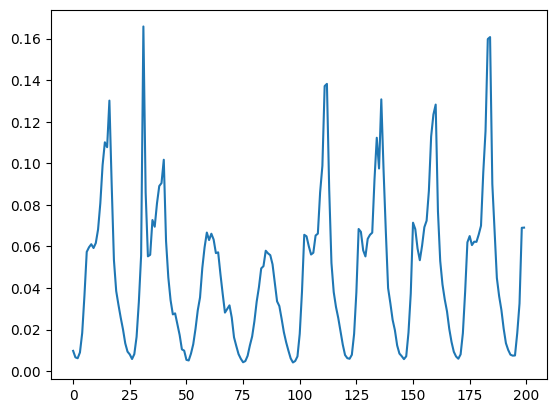

In [148]:
# visualize the data
size = 0
tests = []

for data_entry in test_dataset:
    data = data_entry.copy()
    tests.append(data["target"])
    #print(data.keys())
    #print(data["target"].shape)
test_sample = tests[0]
plt.plot(test_sample[:200])

In [150]:
elec = np.load("./results/traffic_nips_test.npz", allow_pickle=True)
input_data = elec["input_data"]
ground_truth = elec["ground_truth"]
all_mean = elec["all_mean"]
all_lb = elec["all_lb"]
all_ub = elec["all_ub"]
prev_preds = elec["prev_preds"]

preds_concat = np.concatenate([prev_preds, all_mean], axis=1)
truth_concat = np.concatenate([input_data.squeeze(), ground_truth], axis=1)

def create_x_y_from_pred(preds, gts): 
    Xs = []
    Ys = []
    for i in range(len(preds)):
        X, Y = [], []
        for t in range(len(preds[i])):
            X.append(preds[i,t])
            Y.append(gts[i,t])
        Xs.append(X)
        Ys.append(Y)
    return np.array(Xs), np.array(Ys)

Xs, Ys = create_x_y_from_pred(preds_concat, truth_concat)
print(Xs.shape, Ys.shape)

ACI_from_dataset_real(Xs, Ys, test_size=200, t_init=100, name="electricity_from_pred")

(200, 504) (200, 504)


  3%|▎         | 6/200 [00:17<09:29,  2.94s/it]

# Electricity

In [ ]:
ckpt_file = "./Checkpoints/electricity_nips.pt"
ckpt = torch.load(ckpt_file, map_location="cpu")

config = ckpt["config"]
model = build_model(config=config)
model.load_state_dict(ckpt["model"])

test_dataset = get_test_dataset(config)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=80)
extra_args = dict()
extra_args = {"dur_temperature": 1.0}
device = 'cpu'

In [135]:
dataset = datasets.GTSUnivariateDataset("electricity_nips", batch_size=50, mode="test")
test_dataset = dataset.gluonts_dataset

In [46]:

batch_size = 10
assert dataset.metadata["context_length"] == model.context_length
assert dataset.metadata["prediction_length"] == model.prediction_length
prediction_length = dataset.metadata["prediction_length"]
context_length = dataset.metadata["context_length"]
freq = dataset.freq
input_transform = create_input_transform(
    is_train=False,
    prediction_length=prediction_length,
    past_length=context_length,
    use_feat_static_cat=True,
    use_feat_dynamic_real=False,
    freq=freq,
    time_features=None,
)
inference_loader = InferenceDataLoader(
    dataset=test_dataset,
    transform=input_transform,
    batch_size=batch_size,
    stack_fn=batchify,
    #num_workers=1,
)


In [125]:
size = 0
tests = []

for data_entry in test_dataset:
    data = data_entry.copy()
    tests.append(data["target"])
    #print(data.keys())
    #print(data["target"].shape)
test_sample = tests[0]
plt.plot(test_sample[:200])

In [126]:
tests = np.array(tests)
tests.shape, tests[0].shape, tests[0][0].shape

((2590,), (4000,), ())

In [127]:
np.save("./data/electricity_nips/test_arrays.npy", np.array(tests))

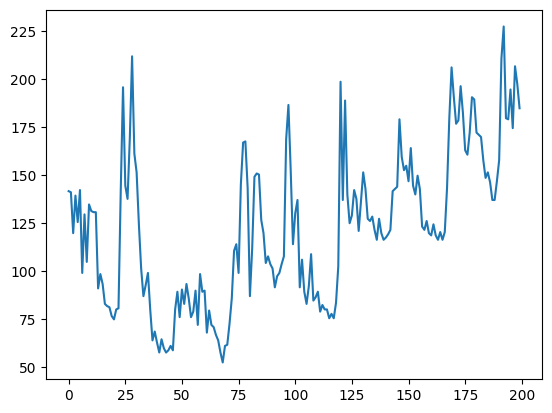

In [133]:
plt.plot(test_sample[:200])

In [98]:
def create_x_y_real(data, context_length=10, max_len=1500):
    Xs = []
    Ys = []
    for data_entry in data:
        if len(data_entry) > max_len:
            data_entry = data_entry[:max_len]
        X = []
        Y = []
        for t in range(len(data_entry)-context_length):
            X.append(data_entry[t:t+context_length])
            Y.append(data_entry[t+context_length])
        Xs.append(np.array(X))
        Ys.append(np.array(Y))
    return np.array(Xs), np.array(Ys)

Xs, Ys = create_x_y_real(tests[:2], context_length=30, max_len=1500)


In [99]:
Xs.shape, Ys.shape

((2, 1470, 30), (2, 1470))

In [122]:

def ACI_from_dataset_real(Xs, Ys, test_size=100, t_init=100, t_predict=168, name=None):

    dataset_name = name if name else "real_data"
    alpha_trajectories = []
    adapt_err_seqs = []
    no_adapt_error_seqs = []
    band_natives = []
    band_adapts = []

    if test_size <= 0:
        test_size = Xs.shape[0]

    for i in tqdm(range(test_size)):
        X, Y = Xs[i], Ys[i]
        alpha_trajectory, adapt_err_seq, no_adapt_error_seq, (band_native, band_adapt) = ACI(Y, X, alpha=0.1, gamma=0.01, t_init=t_init)
        alpha_trajectories.append(alpha_trajectory)
        adapt_err_seqs.append(adapt_err_seq)
        no_adapt_error_seqs.append(no_adapt_error_seq)
        band_natives.append(band_native)
        band_adapts.append(band_adapt)

    np.savez(f"./results/{dataset_name}_aci.npz", 
             alpha_trajectories=alpha_trajectories, 
             adapt_err_seqs=adapt_err_seqs, 
             no_adapt_error_seqs=no_adapt_error_seqs, 
             band_natives=band_natives, 
             band_adapts=band_adapts)
    
    cov_adapt, cov_no_adapt = 1-np.mean(adapt_err_seqs), 1-np.mean(no_adapt_error_seqs)
    std_adapt, std_no_adapt = np.std(np.mean(adapt_err_seqs, axis=1)), np.std(np.mean(no_adapt_error_seqs, axis=1))
    mean_band_native, std_band_native = np.mean(band_natives), np.std(np.mean(band_natives, axis=1))
    mean_band_adapt, std_band_adapt = np.mean(band_adapts), np.std(np.mean(band_adapts, axis=1))
    
    print(f"Adaptive Coverage: {cov_adapt} +/- {std_adapt}")
    print(f"No Adaptive Coverage: {cov_no_adapt} +/- {std_no_adapt}")
    print(f"Adaptive Width: {mean_band_adapt} +/- {std_band_adapt}")
    print(f"No Adaptive Width: {mean_band_native} +/- {std_band_native}")
    return cov_adapt, std_adapt, cov_no_adapt, std_no_adapt, mean_band_native, std_band_native, mean_band_adapt, std_band_adapt

In [113]:
t_init = 100, t_predict= 168
Xs, Ys = create_x_y_real(data, context_length=10, max_len=t_init+t_predict)
print(Xs.shape, Ys.shape)

ACI_from_dataset_real(Xs, Ys, test_size=25, t_init=336, t_predict=168, name="electricity")

(2590, 494, 10) (2590, 494)


100%|██████████| 25/25 [12:29<00:00, 29.97s/it]

Adaptive Coverage: 0.9053164556962026 +/- 0.016550844687272054
No Adaptive Coverage: 0.9106329113924051 +/- 0.0248900804174794
Adaptive Width: 7.962062819367063 +/- 10.844599830537172
No Adaptive Width: 8.559572622709645 +/- 12.503047901287768


(0.9053164556962026,
 0.016550844687272054,
 0.9106329113924051,
 0.0248900804174794,
 8.559572622709645,
 12.503047901287768,
 7.962062819367063,
 10.844599830537172)

In [118]:
# np.savez("./results/electricity_nips_test.npz", input_data=input_data, ground_truth=ground_truth, all_mean=all_mean, all_lb=all_lb, all_ub=all_ub)
elec = np.load("./results/electricity_nips_test.npz", allow_pickle=True)
input_data = elec["input_data"]
ground_truth = elec["ground_truth"]
all_mean = elec["all_mean"]
all_lb = elec["all_lb"]
all_ub = elec["all_ub"]
prev_preds = elec["prev_preds"]

preds_concat = np.concatenate([prev_preds, all_mean], axis=1)
truth_concat = np.concatenate([input_data.squeeze(), ground_truth], axis=1)

In [119]:

def create_x_y_from_pred(preds, gts): 
    Xs = []
    Ys = []
    for i in range(len(preds)):
        X, Y = [], []
        for t in range(len(preds[i])):
            X.append(preds[i,t])
            Y.append(gts[i,t])
        Xs.append(X)
        Ys.append(Y)
    return np.array(Xs), np.array(Ys)


In [121]:
Xs, Ys = create_x_y_from_pred(preds_concat, truth_concat)
Xs.shape, Ys.shape

((200, 504), (200, 504))

In [124]:
ACI_from_dataset_real(Xs, Ys, test_size=200, t_init=100, name="electricity_from_pred")

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [07:38<00:00,  2.29s/it]

Adaptive Coverage: 0.8791336633663367 +/- 0.0036723031212966104
No Adaptive Coverage: 0.6955693069306931 +/- 0.032618832167016734
Adaptive Width: 28.889561572848095 +/- 173.6091729491261
No Adaptive Width: 2.9455168821896276 +/- 27.500763391128476


(0.8791336633663367,
 0.0036723031212966104,
 0.6955693069306931,
 0.032618832167016734,
 2.9455168821896276,
 27.500763391128476,
 28.889561572848095,
 173.6091729491261)

In [52]:
preds = prediction_generator(inference_loader, max_len=1)

0it [00:02, ?it/s]


In [54]:
preds[0].samples.shape

(100, 168)

In [41]:
config["prediction_length"]

168

In [22]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=None)


In [30]:
agg_metrics = evaluation.evaluate_gts_dataset(
        test_dataset,
        model,
        max_len=np.inf,
        device=device,
        deterministic_z=False,
        deterministic_x=False,
        deterministic_y=False,
        batch_size=100,
    )

Running evaluation: 100%|██████████| 2590/2590 [09:05<00:00,  4.75it/s]


In [38]:
14292130.128178215/2590

5518.19696068657

In [37]:
agg_metrics

{'MSE': 351381.9984783112,
 'abs_error': 28248666.993827563,
 'abs_target_sum': 331335992.05908203,
 'abs_target_mean': 761.4818718033691,
 'seasonal_error': 49.33350631716005,
 'MASE': inf,
 'MAPE': 0.12397445936965602,
 'sMAPE': 0.13562604084975316,
 'OWA': nan,
 'MSIS': inf,
 'QuantileLoss[0.1]': 13036353.222644508,
 'Coverage[0.1]': 0.07898051112336826,
 'QuantileLoss[0.2]': 20157036.7751916,
 'Coverage[0.2]': 0.1563430777716492,
 'QuantileLoss[0.3]': 24534016.399135508,
 'Coverage[0.3]': 0.24367300974443828,
 'QuantileLoss[0.4]': 27100850.32727181,
 'Coverage[0.4]': 0.3343951093951094,
 'QuantileLoss[0.5]': 28248667.07919286,
 'Coverage[0.5]': 0.42821980143408717,
 'QuantileLoss[0.6]': 28071364.266605046,
 'Coverage[0.6]': 0.5170159955874241,
 'QuantileLoss[0.7]': 25988784.680744685,
 'Coverage[0.7]': 0.6191947049089906,
 'QuantileLoss[0.8]': 21558598.303100035,
 'Coverage[0.8]': 0.726264019121162,
 'QuantileLoss[0.9]': 14292130.128178215,
 'Coverage[0.9]': 0.839267328553043,
 'RM

In [17]:
test_dataset.metadata["context_length"]

336

In [18]:
test_dataset.metadata["prediction_length"]

168

In [20]:
test_dataset.metadata["n_staticfeat"], test_dataset.metadata["n_timefeat"]

(370, 5)

In [59]:
Xs, Ys = creat_x_y("./data/bouncing_ball_test_1000.npz")

100%|██████████| 50/50 [00:00<00:00, 123.01it/s]


In [60]:
Xs.shape, Ys.shape

((1000, 990, 10), (1000, 990))

In [87]:
Xs, Ys = creat_x_y("./data/bouncing_ball_test_1000.npz")
print(Xs.shape, Ys.shape)
alpha_trajectories = []
adapt_err_seqs = []
no_adapt_error_seqs = []
band_natives = []
band_adapts = []
for i in tqdm(range(100)):
    X, Y = Xs[i], Ys[i]
    alpha_trajectory, adapt_err_seq, no_adapt_error_seq, (band_native, band_adapt) = ACI(Y, X, alpha=0.1, gamma=0.01, t_init=100)
    alpha_trajectories.append(alpha_trajectory)
    adapt_err_seqs.append(adapt_err_seq)
    no_adapt_error_seqs.append(no_adapt_error_seq)
    band_natives.append(band_native)
    band_adapts.append(band_adapt)

100%|██████████| 50/50 [00:00<00:00, 124.28it/s]


(1000, 990, 10) (1000, 990)


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:203: RuntimeWarning: divide by zero encountered in true_divide
  fhat0 = 1. / (nobs * h) * np.sum(kernel(e / h))
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:236: RuntimeWarning: invalid value encountered in multiply
  kernels['epa'] = lambda u: 3. / 4 * (1-u**2) * np.where(np.abs(u) <= 1, 1, 0)


Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
  5%|▌         | 5/100 [03:16<1:00:17, 38.08s/it]

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
  6%|▌         | 6/100 [03:44<54:22, 34.71s/it]  

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
  8%|▊         | 8/100 [04:57<53:47, 35.09s/it]/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
 14%|█▍        | 14/100 [08:11<46:52, 32.71s/it]

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
 15%|█▌        | 15/100 [08:41<45:19, 32.00s/it]/usr/local/Caskroom/miniforge/ba

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
 17%|█▋        | 17/100 [09:40<42:19, 30.60s/it]

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
 18%|█▊        | 18/100 [10:13<43:00, 31.47s/it]

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
 19%|█▉        | 19/100 [10:43<41:40, 30.87s/it]

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
 21%|██        | 21/100 [11:37<38:00, 28.86s/it]

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 500 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 600 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 700 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 800 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 900 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 100 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


Done 200 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 300 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

Done 400 time steps


/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)
/usr/local/Caskroom/miniforge/base/envs/py3/lib/python3.7/site-packages/statsmod

KeyboardInterrupt: 

In [ ]:
1- np.mean(adapt_err_seqs), 1-np.mean(no_adapt_error_seqs)

(0.9013370786516854, 0.8758876404494382)

In [ ]:
np.std(np.mean(adapt_err_seqs, axis=1)), np.std(np.mean(no_adapt_error_seqs, axis=1))


(0.004917434696510483, 0.0767547194556617)

In [ ]:
np.mean(band_natives), np.std(np.mean(band_natives, axis=1)), np.mean(band_adapts), np.std(np.mean(band_adapts, axis=1))

In [ ]:
np.savez("./results/bouncing_ball_aci.npz", alpha_trajectories=alpha_trajectories, adapt_err_seqs=adapt_err_seqs, no_adapt_error_seqs=no_adapt_error_seqs, band_natives=band_natives, band_adapts=band_adapts)

In [90]:
# compile this into a function
def ACI_from_dataset(dataset_path, context_length=10, test_size=100, t_init=100):
    Xs, Ys = creat_x_y(dataset_path, context_length=context_length)
    print(Xs.shape, Ys.shape)

    dataset_name = dataset_path.split("/")[-1].split(".")[0]
    alpha_trajectories = []
    adapt_err_seqs = []
    no_adapt_error_seqs = []
    band_natives = []
    band_adapts = []

    if test_size <= 0:
        test_size = Xs.shape[0]

    for i in tqdm(range(test_size)):
        X, Y = Xs[i], Ys[i]
        alpha_trajectory, adapt_err_seq, no_adapt_error_seq, (band_native, band_adapt) = ACI(Y, X, alpha=0.1, gamma=0.01, t_init=t_init)
        alpha_trajectories.append(alpha_trajectory)
        adapt_err_seqs.append(adapt_err_seq)
        no_adapt_error_seqs.append(no_adapt_error_seq)
        band_natives.append(band_native)
        band_adapts.append(band_adapt)

    np.savez(f"./results/{dataset_name}_aci.npz", 
             alpha_trajectories=alpha_trajectories, 
             adapt_err_seqs=adapt_err_seqs, 
             no_adapt_error_seqs=no_adapt_error_seqs, 
             band_natives=band_natives, 
             band_adapts=band_adapts)
    
    cov_adapt, cov_no_adapt = 1-np.mean(adapt_err_seqs), 1-np.mean(no_adapt_error_seqs)
    std_adapt, std_no_adapt = np.std(np.mean(adapt_err_seqs, axis=1)), np.std(np.mean(no_adapt_error_seqs, axis=1))
    mean_band_native, std_band_native = np.mean(band_natives), np.std(np.mean(band_natives, axis=1))
    mean_band_adapt, std_band_adapt = np.mean(band_adapts), np.std(np.mean(band_adapts, axis=1))
    
    print(f"Adaptive Coverage: {cov_adapt} +/- {std_adapt}")
    print(f"No Adaptive Coverage: {cov_no_adapt} +/- {std_no_adapt}")
    print(f"Adaptive Width: {mean_band_adapt} +/- {std_band_adapt}")
    print(f"No Adaptive Width: {mean_band_native} +/- {std_band_native}")
    return cov_adapt, std_adapt, cov_no_adapt, std_no_adapt, mean_band_native, std_band_native, mean_band_adapt, std_band_adapt

In [95]:
import warnings; warnings.simplefilter('ignore')

ACI_from_dataset("./data/bouncing_ball_test_1000.npz", test_size=100)

100%|██████████| 50/50 [00:00<00:00, 130.41it/s]


(1000, 990, 10) (1000, 990)


 55%|█████▌    | 55/100 [30:55<26:20, 35.11s/it] 

In [ ]:
ACI_from_dataset("./data/bouncing_ball_noisy_test_1000.npz", test_size=100)

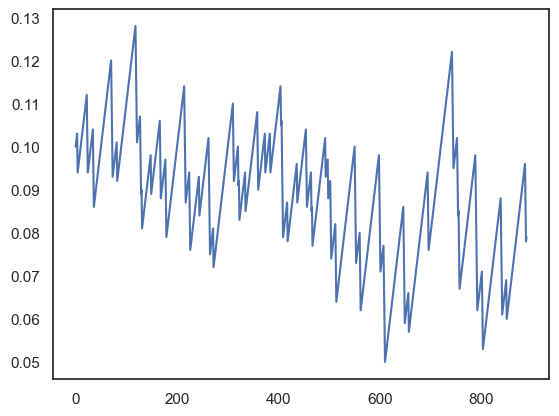

In [80]:
from matplotlib import pyplot as plt
plt.plot(alpha_trajectory)

In [68]:
import seaborn as sns
seed = 111
np.random.seed(seed)
sns.set(style="white")

color_names = ["red",
               "windows blue",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "light cyan",
               "steel blue",
               "pastel purple",
               "mint",
               "salmon"]

colors = sns.xkcd_palette(color_names)
def _plot_segments(ax, segmentation, ymin, ymax):
    s_seq = np.squeeze(segmentation)
    z_cps = np.concatenate(
        ([0], np.where(np.diff(s_seq))[0]+1, [s_seq.size]))
    for start, stop in zip(z_cps[:-1], z_cps[1:]):
        stop = min(s_seq.size, stop+1)
        ax.axvspan(
            start, stop-1, ymin=ymin, ymax=ymax,
            alpha=.8, facecolor=colors[s_seq[start]])

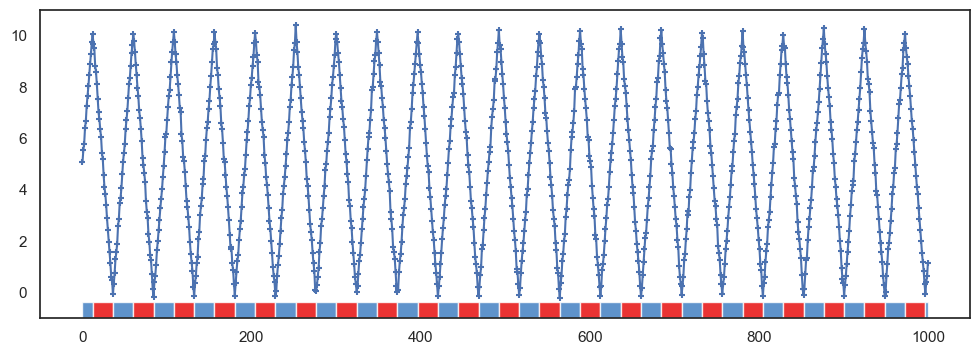

In [77]:
ball = np.load('./data/bouncing_ball_test_1000.npz')
data_y = ball['y']
data_z = ball['z']

idx = 5 #np.random.randint(data_y.shape[0])
y_seq, z_seq = data_y[idx], data_z[idx]
fig = plt.figure(figsize=(12, 4))
ax = fig.gca()
ax.scatter(np.arange(len(y_seq)), y_seq, s=25, marker='+')
ax.plot(np.arange(len(y_seq)), y_seq)
ax.set_ylim([-1, 11.])
_plot_segments(ax, z_seq, 0., 0.05)
plt.show()